# Sentiment Classifier

This notebook contains code for XGBoost to classify the vector representations of sentences.

### Import Libraries

In [1]:
!pip install xgboost

In [2]:
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd

import xgboost
from sklearn import metrics
import matplotlib.pyplot as plt

# from gensim.models import Word2Vec
# from nltk import regexp_tokenize, WordNetLemmatizer

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Input

In [4]:
df_positive = pd.read_csv('positive.csv')
df_positive['y'] = 1

df_negative = pd.read_csv('negative.csv')
df_negative['y'] = 0

df_train = pd.concat([df_positive, df_negative], axis=0, ignore_index=True, sort=False).drop(columns=['Unnamed: 0'])
df_train = df_train.reset_index(drop=True)
df_train

x_train, y_train = df_train.drop('y', axis=1), df_train['y']

In [5]:
df_positive_gen = pd.read_csv('positive_generated.csv')
df_positive_gen['y'] = 1

df_negative_gen = pd.read_csv('negative_generated.csv')
df_negative_gen['y'] = 0

df_test = pd.concat([df_positive_gen, df_negative_gen], axis=0, ignore_index=True, sort=False).drop(columns=['Unnamed: 0'])
df_test = df_test.reset_index(drop=True)
df_test

x_test, y_test = df_test.drop('y', axis=1), df_test['y']

In [6]:
x_train

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,0.000539,-0.002841,0.001038,0.001227,0.001702,-0.000181,-0.000825,0.001076,-0.003619,0.001606,...,0.003034,-0.002670,0.001494,0.000342,0.001086,-0.002365,-0.000088,0.001719,0.000227,0.002161
1,0.000121,0.001598,-0.002022,0.003518,-0.000634,-0.002769,-0.000015,0.004520,-0.003272,-0.001034,...,0.002906,0.001636,0.000892,-0.001251,0.005686,0.001471,-0.000284,-0.003353,-0.000166,0.000829
2,-0.002452,0.002751,-0.001009,-0.002248,0.006385,-0.002959,0.003530,0.001689,-0.001781,-0.000203,...,-0.000772,-0.001953,0.001702,-0.004471,-0.001321,0.002298,0.002728,-0.002785,0.000267,0.000292
3,-0.003758,0.000238,0.001691,0.002436,-0.001121,-0.004381,0.002311,0.002936,-0.003526,-0.001478,...,0.006063,0.002834,-0.001215,0.001329,-0.000051,0.000017,-0.000712,0.000364,-0.000582,0.004109
4,-0.003734,0.001693,0.000943,-0.000015,0.003691,-0.002938,-0.001058,0.002985,-0.002023,0.000893,...,-0.003025,-0.001639,-0.002646,-0.001628,0.002200,0.001421,-0.002657,0.000847,0.001100,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,-0.000828,0.001477,0.002940,0.000595,0.001523,-0.000404,0.000284,0.002123,-0.000700,-0.000375,...,-0.001677,-0.001745,-0.001104,-0.001014,0.001452,0.001703,0.001786,-0.005261,-0.000980,0.004666
333,0.000383,-0.000077,-0.002621,0.000914,-0.005285,0.002970,0.001621,-0.003106,-0.005056,-0.005158,...,0.004112,-0.000337,0.002719,-0.000342,-0.002319,-0.001741,0.001024,-0.004805,0.001432,0.001137
334,0.002676,-0.000389,0.002747,0.002768,-0.001215,0.000844,0.000177,0.002195,-0.000846,-0.004233,...,-0.000457,0.000097,-0.005863,-0.000197,0.004185,0.002983,-0.003276,-0.003367,-0.002619,-0.001965
335,-0.005223,0.001633,-0.001118,0.001054,-0.001881,-0.001437,-0.002837,0.000140,0.002687,0.000493,...,-0.000293,-0.001411,-0.000660,-0.002264,0.000308,0.004514,-0.002617,0.000905,-0.001918,-0.001979


In [7]:
x_test

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,-0.001082,0.000342,-0.000149,0.000428,-0.000528,-0.000454,-0.000242,0.000990,-0.000314,0.000702,...,0.000651,0.000674,0.000108,0.000309,0.000466,0.000240,0.000591,-0.000158,0.000999,-0.000105
1,-0.000311,0.000125,0.000210,-0.000167,0.000107,-0.001808,0.001462,0.000493,-0.000328,-0.000312,...,0.000457,0.000667,0.000012,-0.000221,0.001715,0.000128,0.000668,-0.000883,0.000340,-0.000636
2,0.000445,0.000575,0.000079,0.000117,-0.000230,-0.000876,0.000163,0.000435,-0.000954,-0.000062,...,0.000767,-0.000486,0.000132,0.000398,-0.000583,0.000017,0.000760,-0.000227,0.001136,-0.000020
3,-0.000160,-0.000825,0.000339,0.000391,0.000316,-0.000717,-0.001572,0.001637,-0.000065,0.000037,...,0.000824,0.000024,-0.000409,-0.000482,0.001341,0.000943,-0.001140,0.000126,-0.000114,-0.000445
4,0.000712,0.001226,-0.000400,-0.000382,0.000909,0.000169,0.001546,0.001520,0.000057,-0.001540,...,0.001108,0.001182,0.000005,0.000024,-0.000051,0.001168,0.000562,-0.001303,-0.000370,0.000384
5,-0.000616,-0.000162,-0.000671,0.000768,-0.001334,-0.000871,-0.000537,0.000711,-0.000420,0.000655,...,0.000434,0.000768,-0.000075,0.000193,0.000314,0.000973,0.000138,-0.000011,0.000423,-0.001009
6,0.000027,0.000058,0.000543,0.000483,0.000802,-0.000478,0.001076,0.000831,-0.000249,-0.000019,...,0.001092,0.001031,-0.000393,0.000519,0.001661,-0.000452,0.000307,-0.001722,0.000478,0.000359
7,-0.000106,-0.000641,-0.000373,0.000291,0.000176,-0.001206,0.000184,0.000133,0.000293,0.000619,...,0.000901,-0.000236,0.000295,0.000194,-0.000160,0.000867,0.000472,-0.000247,0.000738,-0.000888
8,-0.000291,0.000453,0.000718,-0.000140,0.000211,-0.000688,0.000363,0.001737,-0.000351,-0.000749,...,0.001308,0.000426,-0.000056,-0.000553,0.000964,0.000263,-0.000901,-0.000380,-0.000593,0.000548
9,0.000468,0.001932,0.000160,-0.000494,0.000595,-0.000577,0.000644,0.001340,-0.000773,-0.001599,...,0.000309,0.000071,-0.000304,-0.000064,0.000290,0.000762,0.001195,-0.000190,0.000831,0.000315


In [9]:
import time


xgb = xgboost.XGBClassifier(n_estimators=1000)

training_start = time.perf_counter()
xgb.fit(x_train, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds = xgb.predict(x_test)
prediction_end = time.perf_counter()

acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 50.00
Time consumed for training: 3.031
Time consumed for prediction: 0.01192 seconds


In [10]:
preds

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 0])

Accuracy: 50.00%


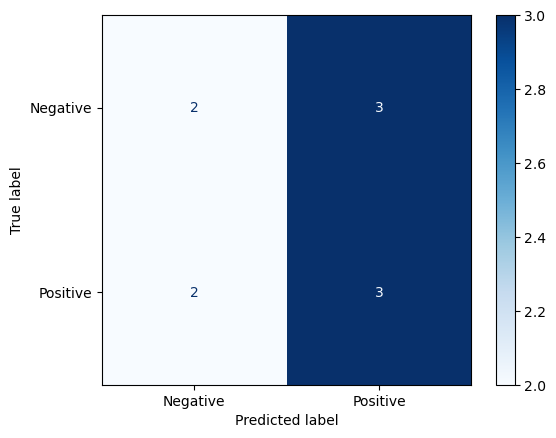

In [11]:
accuracy = metrics.accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy*100:.2f}%")


confusion_matrix = metrics.confusion_matrix(y_test, preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Negative", "Positive"])

cm_display.plot(cmap=plt.cm.Blues)